In [1420]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tqdm import tqdm
import re

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# df = pd.read_csv("data2/jobs2.csv")
# df = df.loc[(df["keyword"] != "Künstliche_Intelligenz") & (df["keyword"] != "Artificial_Intelligence")]
# df.drop("keyword", axis=1, inplace=True)
# df.drop_duplicates(inplace=True)
# df.shape

In [81]:
# df = pd.read_csv("data2/jobs2.csv")
# df.drop("keyword", axis=1, inplace=True)
# df.drop_duplicates(inplace=True)
# df.shape

In [958]:
data_raw = pd.read_csv("data2/jobs_updated.csv")
data_raw.shape

(3761, 14)

In [927]:
data_raw.head()

,link,company,title,location,content,industry,rating,num_ratings,company_link,release_date,salary,company_size,contract_type,work_type
0,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,"Walldorf, Stuttgart, München, Leipzig, Hamburg...",Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,NaN,2501-5000,Feste Anstellung,"Vollzeit, Home Office möglich"
1,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Berlin,Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,51.000 - 68.000 €,NaN,Feste Anstellung,"Vollzeit, Home Office möglich"
2,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,"Dortmund, Düsseldorf, Aachen",Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,51.000 - 74.000 €,NaN,Feste Anstellung,"Vollzeit, Home Office möglich"
3,https://www.stepstone.de/stellenangebote--Data...,METRO Markets GmbH,Data Science Lead,"Düsseldorf, Palma de Mallorca",We create the future of B2B commerce by giving...,IT & Internet,NaN,NaN,NaN,2022-06-01,74.000 - 98.000 €,NaN,Feste Anstellung,"Vollzeit, Home Office möglich"
4,https://www.stepstone.de/stellenangebote--Werk...,CHECK24,Werkstudent BI und Data Science Manager (m/w/d...,München,"Bist Du bereit, etwas zu bewegen und neue, spa...",Finanzdienstleister|Versicherungen,4.5,179 Bewertungen,https://www.stepstone.de/cmp/de/CHECK24-112642...,2022-06-01,NaN,2501-5000,"Studentenjobs, Werkstudent",Teilzeit


In [928]:
data_raw.isnull().sum()

link                0
company             0
title               0
location            0
content             0
industry          637
rating           1137
num_ratings      1137
company_link      751
release_date        0
salary           1643
company_size      974
contract_type       0
work_type           0
dtype: int64

Vorgehen:
- für die Gehaltprognose sind nur Vollzeit Jobs mit Festanstellung relevant
    - zwei Dataframes erzeugen: gefiltert/ungefiltert
    - auf dem gefilterten DF werden alle Gehaltsstatistiken ausgewertet
    - anschließend werden die Transformationen auf dem ungefilterten DF ausgeführt und auf Edge Cases untersucht
- Gehalt umwandeln
- Jobtitel klassifizieren
- Standorte säubern ==> zwei Dataframes erzeugen
    - Long-Format ==> Visualisierung der Standorte (Jobs können mehrfach enthalten sein)
    - Wide-Format ==> alle weiteren Analysen (jeder Job darf nur einmal enthalten sein)
        - Data Cleaning im Long-Format durchführen und anschließend wieder zurück transformieren
        - zusätzliche Features erzeugen (z.B. Anzahl der Standorte, Hauptstandort, binäre Features für Großstädte)
- Branchen umwandeln
    - OHE zum späteren Filtern nutzen
    - zusätzliches Feature mit erster Branche behalten 
- Bewertungen / Anzahl der Bewertungen / Unternehmensgröße ist korrektes Format umwandeln
- Text Mining auf den Inhalten der Jobbeschreibung durchführen

# Evaluate Contract Type

Die erhaltenen Jobbeschreibungen fallen in viele unterschiedliche Kategorien, von denen viele jedoch für die kommende Analyse nicht relevant sind. Daher solllen in diesem Abschnitt zunächst alle nicht relevanten Anzeigen aus den Daten entfernt werden.

In [929]:
data_raw["contract_type"].value_counts()

Feste Anstellung                                                            3218
Befristeter Vertrag                                                          151
Studentenjobs, Werkstudent                                                   117
Praktikum                                                                     95
Berufseinstieg/Trainee                                                        47
Ausbildung, Studium                                                           44
Praktikum, Studentenjobs, Werkstudent                                         28
Bachelor-/Master-/Diplom-Arbeiten                                             23
Promotion/Habilitation                                                        14
Feste Anstellung, Berufseinstieg/Trainee                                       9
Bachelor-/Master-/Diplom-Arbeiten, Praktikum                                   5
Arbeitnehmerüberlassung                                                        4
Feste Anstellung, Ausbildung

Da einige Jobanzeigen mehrere Kategorien angeben, werden diese im folgenden für eine bessere Übersicht voneinander getrennt.

In [930]:
contracts = data_raw["contract_type"].str.replace(", ", ",").str.get_dummies(",")
contracts.sum().sort_values(ascending=False)

Feste Anstellung                     3230
Befristeter Vertrag                   151
Studentenjobs                         148
Werkstudent                           148
Praktikum                             129
Berufseinstieg/Trainee                 56
Ausbildung                             45
Studium                                45
Bachelor-/Master-/Diplom-Arbeiten      30
Promotion/Habilitation                 14
Arbeitnehmerüberlassung                 5
Freie Mitarbeit/Projektmitarbeit        1
dtype: int64

Die einzigen Kategorien, die im weiteren Verlauf der Datenanalyse weiter betrachtet werden, sind "Feste Anstellung" und "Berufseinstieg/Trainee". Die restlichen Kategorien könnten theoretisch ebenfalls noch gesondert betrachtet werden. Aufgrund der teilweise sehr geringen Stichprobengrößen, wäre dies für die vorliegenden Daten jedoch nicht besonders aussagekräftig.

In [1259]:
def filter_contract_types(df):
    df_new = df.copy()
    df_new["permanent_employment"] = df_new["contract_type"].str.contains("Feste Anstellung")
    df_new["trainee"] = df_new["contract_type"].str.contains("Trainee")
    df_new = df_new.loc[(df_new["permanent_employment"] == 1) | (df_new["trainee"] == 1)]
    df_new = df_new.drop("contract_type", axis=1)
    return df_new

data_cleaned = filter_contract_types(data_raw)
data_cleaned.shape

(3277, 15)

In [943]:
data_cleaned.columns

Index(['link', 'company', 'title', 'location', 'content', 'industry', 'rating',
       'num_ratings', 'company_link', 'release_date', 'salary', 'company_size',
       'work_type', 'permanent_employment', 'trainee'],
      dtype='object')

# Evaluate Work Type

In [945]:
data_cleaned["work_type"].value_counts()

Vollzeit                                   1893
Vollzeit, Home Office möglich              1093
Vollzeit, Teilzeit, Home Office möglich     171
Vollzeit, Teilzeit                          107
Teilzeit                                     10
Teilzeit, Home Office möglich                 3
Name: work_type, dtype: int64

Unter den Jobbeschreibungen befinden sich sowohl Vollzeit- als auch Teilzeitjobs. Einige dieser Jobs können außerdem optional im Home Office durchgeführt werden. Da das Attribut "work_type" auch mehrere dieser Kategorien enthalten kann, wird es nachfolgend in drei einzelne Attribute aufgespaltet.

In [1260]:
def convert_work_types(df):
    df_new = df.copy()
    work_types = data_cleaned["work_type"].str.replace(", ", ",").str.get_dummies(",").astype("bool")
    work_types = work_types.rename({"Vollzeit": "full_time", "Teilzeit": "part_time", "Home Office möglich": "home_office_possible"}, axis=1)
    df_new = pd.concat([df_new, work_types], axis=1)
    df_new = df_new.drop("work_type", axis=1)
    return df_new

data_cleaned = convert_work_types(data_cleaned)
data_cleaned.shape

(3277, 17)

# Evaluate Job Title

Das Problem bei Analyse der Jobtitel besteht darin, dass diese in keinem einheitlichen Format vorliegen und somit fast jeder Name einzigartig ist. Daher wird an dieser Stelle versucht, die Titel mit Hilfe einiger Regel in verschiedene Kategorien einzuteilen.

In [1081]:
data_cleaned["title"].nunique()

3041

In [1122]:
data_cleaned["title"].value_counts()

Data Engineer (m/w/d)                                                            22
Data Scientist (m/w/d)                                                           18
Data Analyst (m/w/d)                                                             17
Data Engineer (w/m/d)                                                             9
Data Engineer (m/f/d)                                                             7
                                                                                 ..
Senior Sales Manager IT Solutions (m/w/d)                                         1
W2‑Professur für Industrie 4.0 / IoT / Cyberphysische Systeme (m/w/d)             1
Spezialist Global Pricing (m/w/d)                                                 1
Sensor Fusion Data Engineer C++ / Python for L4 Autonomous Driving (f/m/div.)     1
Senior Analyst im Bereich Economic Intelligence (w/m/d)                           1
Name: title, Length: 3041, dtype: int64

Um einen Überblick über häufig vorkommende Muster in den Jobtiteln zu bekommen, werden alle Titel zu einem einzigen String zusammengefasst und das vorkommen einzelner Wörter und Kombinationen an Wörter gezählt. 

In [975]:
stop_eng = set(stopwords.words('english'))
stop_ger = set(stopwords.words('german'))
stop_all = stop_eng.union(stop_ger)
len(stop_all)

405

In [1082]:
# CountVectorizer erwatet eigentlich mehrere Beispiele
l = []
l.append(title_text)

vectorizer = CountVectorizer(ngram_range=(2,3))
vector = vectorizer.fit_transform(l)
results = pd.DataFrame({"keyword": vectorizer.get_feature_names_out(), "count": vector.toarray().reshape(-1)})
results = results.loc[~results["keyword"].isin(stop_eng.union(stop_ger))]
results.sort_values("count", ascending=False).head(20)

,keyword,count
6042,data engineer,284
5787,data analyst,220
6393,data scientist,203
21854,senior consultant,151
21919,senior data,150
12227,im bereich,150
9009,engineer data,108
6336,data science,98
15426,machine learning,93
5900,data analytics,88


Auf Basis der erhaltenen Erkenntnisse wurde ein Reihe von Regeln mit Hilfe regulärer Ausdrücke gebildet, die die vorhandenen Jobtitel in die folgenden Kategorien einteilt:
- Software Engineer
- Data Analyst
- Data Scientist
- Data Engineer
- Machine Learning Engineer
- Data Science Consultant
- Data Science Manager

Ein Problem, welches während der Herleitung der Regeln deutlich wurde ist, dass die erhaltenen Kategorien nicht exklusiv sind. So enthalten bespielweise einige Jobtitel die Bezeichung "Data Analyst/Scientist". Aus diesem Grund wurde sich dafür entschieden, die Einteilung hierarchisch vorzunehmen und uneindeutige Jobtitel im Zweifelsfall mit der übergeordneten Kategorie zu überschreiben.

In [1280]:
def convert_title(df):
    df_new = df.copy()
    df_new["title_category"] = "Others"
    df_new.loc[df_new["title"].str.contains("Software|Developer|Entwickler", case=False, regex=True), "title_category"] = "Software Engineer"
    df_new.loc[df_new["title"].str.contains("Analyst|Business[- ]*Intelligence|Analytics|Reporting", case=False, regex=True), "title_category"] = "Data Analyst"
    df_new.loc[df_new["title"].str.contains("Data[ \S]*Scien|Research[ \S]*(Scientist|Engineer)|Statistik", case=False, regex=True), "title_category"] = "Data Scientist"
    df_new.loc[df_new["title"].str.contains("(Data|Cloud)[ \S]*(Engineer|Archite(c|k)t|Specialist)|Data Warehouse|Datenbank|Database", case=False, regex=True), "title_category"] = "Data Engineer"
    df_new.loc[df_new["title"].str.contains("Machine[- ]*Learning|Deep[- ]*Learning|(\W|^)(AI|KI|ML|DL)(\W|$)|Artificial[- ]*Intelligence|Künstliche[- ]*Intelligenz|MLOps", case=False, regex=True), "title_category"] = "Machine Learning Engineer"   
    df_new.loc[df_new["title"].str.contains("Consultant|Berater|Consulting", case=False, regex=True), "title_category"] = "Data Science Consultant"
    # df_new.loc[df_new["title"].str.contains("Manager|Head|Lead|Leiter|Leitung|Vorstand|Chief|(?<!Daten)(?<!Data )Management|Owner|Partner|Director", case=False, regex=True), "title_category"] = "Data Science Manager" 
    df_new.loc[df_new["title"].str.contains("Manager|Head|Lead|Leiter|Leitung|Vorstand|Chief|Owner|Partner|Director", case=False, regex=True), "title_category"] = "Data Science Manager" 
    return df_new

data_cleaned = convert_title(data_cleaned)
print(data_cleaned["title"].nunique())
data_cleaned["title_category"].value_counts()

3041


C:\Users\joach\AppData\Local\Temp\ipykernel_19968\432586902.py:6: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\joach\AppData\Local\Temp\ipykernel_19968\432586902.py:7: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\joach\AppData\Local\Temp\ipykernel_19968\432586902.py:8: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



Data Science Manager         746
Others                       660
Data Science Consultant      401
Software Engineer            400
Data Analyst                 362
Data Engineer                358
Data Scientist               202
Machine Learning Engineer    148
Name: title_category, dtype: int64

Es wird deutlich, dass mehrere Jobanzeigen keiner der definierten Kategorien zugeordnet werden konnten. Dies liegt daran, dass beim Scrapen der Anzeigen nicht nur exakte Jobtitel sondern zusätzlich auch nach Keywords wie "Data Science" oder "Machine Learning" gesucht wurde, um möglichst viele mögliche Jobtitel zu integrieren. Dadurch wurden jedoch auch Jobs mit aufgenommen, bei denen das Unternehmen zwar in Richtung Data Science orientiert ist, der eigentliche Job aber nicht viel damit zu tun hat. Da mit den vorhandenen Regel versucht wurde alle relevanten Jobs bestmöglich zu erfassen, können alle weiteren Einträge von der weiteren Analyse ausgeschlossen werden.

In [1282]:
# with pd.option_context("display.max_colwidth", None):
#     print(data_cleaned.loc[(data_cleaned["title"].str.contains("cloud", case=False)) & (data_cleaned["title_category"] == "Others"), "title"].head(20))

In [1283]:
with pd.option_context("display.max_colwidth", None):
    print(data_cleaned.loc[data_cleaned["title_category"] == "Others", "title"].head(10))

133                                                        Sr. Experience Researcher, International Product Led Growth
137                                                                                            DevOps Engineer (m/w/d)
162                                                                        Referent RTL Data (w/m/d) (RTL Deutschland)
195                                                                                     Digital Health Experte (m/w/d)
202                                                                                     IT Systemadministrator (m/w/d)
203                                                                                     Mathematiker (m/w/d) Aktuariat
206    IT-Experte/IT-Spezialist/in (m/w/d)\nTelekommunikationsüberwachung und Elektronische Schnittstelle der Behörden
207            IT-Experte/IT-Spezialist/in (w/m/d)\nTelekommunikationsüberwachung / Informationstechnische Überwachung
212                                             

In [1284]:
data_cleaned = data_cleaned.loc[data_cleaned["title_category"] != "Others"]
data_cleaned["title_category"].value_counts()

Data Science Manager         746
Data Science Consultant      401
Software Engineer            400
Data Analyst                 362
Data Engineer                358
Data Scientist               202
Machine Learning Engineer    148
Name: title_category, dtype: int64

In [1233]:
data_cleaned.shape

(2663, 19)

Weiterhin kann einigen Jobtiteln zusätzlich das benötigte Erfahrungslevel für die Position entnommen werden.

In [1285]:
def extract_experience(df):
    df_new = df.copy()
    df_new["experience"] = "No Information"
    df_new.loc[df_new["title"].str.contains("Junior|Jr.", case=False), "experience"] = "Junior"
    df_new.loc[df_new["title"].str.contains("Senior|Sr.", case=False), "experience"] = "Senior"
    return df_new

data_cleaned = extract_experience(data_cleaned)
data_cleaned["experience"].value_counts()

No Information    1885
Senior             601
Junior             131
Name: experience, dtype: int64

# Evaluate Salary

In [1286]:
def convert_salary(df):
    min_salaries = df["salary"].str.split(" ").str[0].str.replace(".", "", regex=False).astype("float")
    max_salaries = df["salary"].str.split(" ").str[2].str.replace(".", "", regex=False).astype("float")
    df["average_salary"] = (min_salaries + max_salaries) / 2
    df.drop("salary", axis=1, inplace=True)
    return df

data_cleaned = convert_salary(data_cleaned)
data_cleaned.shape

(2617, 19)

<AxesSubplot:xlabel='average_salary'>

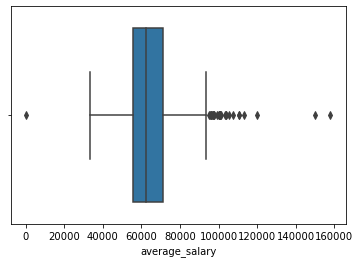

In [1287]:
sns.boxplot(x=data_cleaned["average_salary"])

Bei der Betrachtung der Gehälter wird ein Ausreißer nahe 0 deutlich, der eigentlich nicht existieren dürfte. Eine nähere Betrachtung der Jobanzeige zeigt, dass der Rest der Daten komplett in Ordnung sind. Daher wurde sich an dieser Stelle dafür entschieden, die Anzeige in den Daten zu behalten und das Gehalt auf NaN zu setzen.

In [1289]:
data_cleaned.loc[data_cleaned["average_salary"]<25000]

,link,company,title,location,content,industry,rating,num_ratings,company_link,release_date,company_size,permanent_employment,trainee,home_office_possible,part_time,full_time,title_category,experience,average_salary
2486,https://www.stepstone.de/stellenangebote--Expe...,Home Shopping Europe GmbH,Expert (m/w/d) Operations Analytics,"Ismaning, Raum München","Zwischen Excelsheets und Live-TV, zwischen For...",IT & Internet,4.3,49 Bewertungen,https://www.stepstone.de/cmp/de/Home-Shopping-...,2022-05-25,501-1000,True,False,True,False,True,Data Analyst,No Information,1.0


In [1290]:
data_cleaned.loc[data_cleaned["average_salary"]<25000, "average_salary"] = np.nan

<AxesSubplot:xlabel='average_salary'>

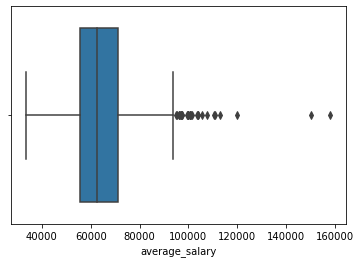

In [1291]:
sns.boxplot(x=data_cleaned["average_salary"])

Auch auf der rechten Seite existieren zwei Ausreißer. Bei nährerer Betrachtung wird jedoch deutlich, dass es sich hierbei um valide Datenpunkte handelt. Deshalb werden diese nicht aus den Daten entfernt. Beim späteren Training eines Machine Learning Modelles kann es jedoch sinnvoll sein, diese aus den Trainingsdaten auszuschließen, um die gelernten Beziehungen nicht zu verzerren.

In [1294]:
data_cleaned.loc[data_cleaned["average_salary"]>120000]

,link,company,title,location,content,industry,rating,num_ratings,company_link,release_date,company_size,permanent_employment,trainee,home_office_possible,part_time,full_time,title_category,experience,average_salary
1060,https://www.stepstone.de/stellenangebote--VP-G...,Evotec SE,VP Global Head Cellular Sciences (f/m/d),Hamburg,Evotec is a life science company with a uniqu...,Pharmaindustrie,3.6,5 Bewertungen,NaN,2022-06-03,NaN,True,False,False,False,True,Data Science Manager,No Information,158000.0
3124,https://www.stepstone.de/stellenangebote--Supp...,Elmar Hertzog und Partner Management Consultan...,Supply Chain Strategy Director (f/m/d),Berlin,Hertzog & Partner was founded in 1978 and sinc...,NaN,NaN,NaN,NaN,2022-06-01,NaN,True,False,False,False,True,Data Science Manager,No Information,150000.0


# Evaluate Location

In diesem Abschnitt werden die geografischen Informationen der Jobanzeigen verarbeitet. Ein erster Überblick über die Daten zeigt, dass Einträge existieren, für die mehrere Standorte angegeben sind. Für eine nähere Analyse müssen diese Einträge in mehrere Zeilen aufgesplittet werden, sodass jeder Eintrag nur noch einen einzigen Standort enthält.

In [1301]:
data_cleaned["location"].value_counts().head(20)

München                                                         212
Berlin                                                          207
Hamburg                                                         116
Stuttgart                                                       112
Düsseldorf                                                       73
Frankfurt am Main                                                59
Köln                                                             57
bundesweit                                                       49
Renningen                                                        33
Berlin, Frankfurt am Main, Hamburg, Köln, München, Stuttgart     30
Karlsruhe                                                        25
Hannover                                                         21
Ulm                                                              19
Essen                                                            18
Leonberg                                        

In [1309]:
num_words = data_cleaned["location"].str.split(",").str.len()
num_words.value_counts()

1     1779
2      202
3      120
6      108
4       82
7       71
5       70
10      65
8       59
9       41
11      19
12       1
Name: location, dtype: int64

Bei Betrachtung der geplitteten Werte wird deutlich, dass die Daten in keinem einheitlichen Format vorliegen. Für die Stadt "Frankfurt" liegen vier unterschiedliche Schreibweisen vor. Außerdem müssen Begriffe wie "bundesweit" oder "Home-Office" vereinheitlicht werden.

In [1308]:
data_cleaned["location"].str.split(", ").explode().value_counts().head(20)

München              710
Berlin               659
Hamburg              516
Stuttgart            434
Düsseldorf           362
Köln                 360
Frankfurt am Main    248
Hannover             157
Frankfurt            152
Nürnberg             124
Leipzig               78
Dortmund              74
bundesweit            73
Karlsruhe             68
Frankfurt (Main)      66
Essen                 63
Münster               37
Home-Office           36
Frankfurt a. M.       36
Ratingen              35
Name: location, dtype: int64

Um alle Daten in ein einheitliches Format zu bringen sind eine Reihe unterschiedlicher Regeln erforderlich. Der Überichtlichkeit halber wurden an dieser Stelle alle erhaltenen Regeln in einer Funktion zusammengefasst und auf die Herleitung und Funktionsweise der einzelnen Regeln verzichtet.

In [1354]:
# die folgende Funktion extrahiert die einzelnen Städtenamen mittels Regulärer Ausdrücke
# die letzten Regel sind relativ individuell auf die verwendeten Daten abgestimmt
# ==> müssten für neue Daten eventuell nochmal überarbeitet werden

def extract_locations(df):
    locations = df["location"].str.split(", ?").explode()
    locations = locations.str.split(" ?/ ?").explode()
    locations = locations.str.split(" oder ").explode()
    locations = locations.str.split(" und ").explode()
    locations = locations.str.split(" - ").explode()
    locations = locations.str.split("; ").explode()
    locations = locations.str.split(" ?\+ ?").explode()
    locations = locations.replace("^Raum ", "", regex=True)
    locations = locations.str.replace(" \(?(bei|b\.|an|am|a\.|ob|in|im|vor|v\.|\+|%|u\.a\.|Raum)[)\w\d .]+", "", regex=True)
    locations = locations.str.replace("[ \w-]*(Home|Office|Mobile|Remote|Bundes|Deutschland|Wahl|Standort|DACH|keine Angabe)[( \w-]*", "bundesweit", case=False, regex=True)
    locations = locations.str.replace(" ?(a\.M\.|Main|M\.|\.\.\.und weitere|Gutenbergquartier)$", "", regex=True)
    locations = locations.str.replace("(MBTI|bei|\d{5}|Metropolregion|Fürstentum|Großraum|100%) ?", "", regex=True)
    locations = locations.str.replace("St.", "Sankt", regex=False)
    locations = locations.str.replace(".", "", regex=False)
    locations = locations.str.split(" \(").explode()
    locations = locations.where(locations.str.contains("^(Bad|Sankt|Palma|New|Den|Schwäbisch|Lindau) ", regex=True), locations.str.split(" ")).explode()
    locations = locations.str.strip("[ )]")
    locations = locations.replace("^$", np.nan, regex=True)
    return locations

locs = extract_locations(data_cleaned)
# das Joinen über der Index ist möglich, da dieser bei der explode()-Methode dupliziert wird
data_long = pd.merge(data_cleaned, locs, left_index=True, right_index=True, how="left", suffixes=["_x", None])
data_long = data_long.drop("location_x", axis=1)
print(data_long.index.nunique())
data_long["location"].value_counts().head(20)

2617


C:\Users\joach\AppData\Local\Temp\ipykernel_19968\563081657.py:21: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



München         747
Berlin          681
Frankfurt       571
Hamburg         538
Stuttgart       452
Köln            382
Düsseldorf      377
bundesweit      226
Hannover        163
Nürnberg        138
Leipzig          80
Dortmund         76
Main             74
Essen            72
Karlsruhe        71
Mannheim         40
Ulm              38
Ratingen         37
Münster          37
Ludwigshafen     36
Name: location, dtype: int64

In [1329]:
df_long.shape

(6312, 19)

In [1356]:
data_long.to_csv("data2/cleaned_long2.csv", index=False)

Für eine regionale Analyse der Jobs war es notwendig, zusätzliche Informationen zu sammeln. Die Website https://positionstack.com/ bietet eine kostenlose API, um zu beliebigen Adressen die Geo-Koordinaten, sowie weitere Informationen wie Land oder Bundesland zurückzugeben. Im Code der positionstack.py wird für jeden im abgespeicherten Dataframe enthaltenen Standort ein GET-Request an die Positionstack-API gesendet, um die gewünschten Informationen zu erhalten.

In [1388]:
geo_data = pd.read_csv("data2/geo_data2.csv")
geo_data.head()

,latitude,longitude,type,name,number,postal_code,street,confidence,region,region_code,county,locality,administrative_area,neighbourhood,country,country_code,continent,label,location
0,49.307822,8.641450,locality,Walldorf,NaN,NaN,NaN,1.0,Baden-Württemberg,BW,Rhein-Neckar-Kreis,Walldorf,Walldorf,NaN,Germany,DEU,Europe,"Walldorf, BW, Germany",Walldorf
1,48.706310,9.119240,locality,Stuttgart,NaN,NaN,NaN,1.0,Baden-Württemberg,BW,Esslingen,Stuttgart,Leinfelden-Echterdingen,NaN,Germany,DEU,Europe,"Stuttgart, BW, Germany",Stuttgart
2,48.152126,11.544467,locality,Munich,NaN,NaN,NaN,1.0,Bavaria,BY,Munich,Munich,München,NaN,Germany,DEU,Europe,"Munich, BY, Germany",München
3,51.341053,12.404024,locality,Leipzig,NaN,NaN,NaN,1.0,Saxony,SN,Leipzig,Leipzig,Leipzig,NaN,Germany,DEU,Europe,"Leipzig, SN, Germany",Leipzig
4,53.576158,10.007046,locality,Hamburg,NaN,NaN,NaN,1.0,Hamburg,HH,Hamburg,Hamburg,Hamburg,NaN,Germany,DEU,Europe,"Hamburg, Germany",Hamburg


Die Übersicht aller fehlenden Werte zeigt, dass zu einigen Standorten keine Informationen abgerufen werden konnten. Eine nähere Analyse zeigt, dass es sich hierbei entweder im Jobs ohne festgeschriebenen Standort handelt oder um Standorte im Ausland. Da es sich hierbei lediglich um eine Analyse in Deutschland handelt können diese Standorte ohne Probleme aus den Daten entfernt werden.

In [1389]:
geo_data.isnull().sum()

latitude                12
longitude               12
type                    12
name                    12
number                 360
postal_code            360
street                 360
confidence              12
region                  13
region_code             13
county                  22
locality                19
administrative_area     19
neighbourhood          356
country                 12
country_code            12
continent               12
label                   12
location                 1
dtype: int64

In [1391]:
geo_data.loc[geo_data["latitude"].isnull(), "location"].unique()

array(['bundesweit', 'Abingdon', 'Villach', 'Oensingen', 'Tallin',
       'Liechtenstein', 'Dordrecht', 'Fuschl', 'Gutenbergquartier',
       'Pilsen', 'bundesweit–bundesweit', 'Österreichweit'], dtype=object)

Leider kann mit der Positionstack-API nicht in den Parametern festgelegt werden, dass nur Orte gefiltert werden sollen. Daher ist es möglich, dass  der Name einiger ausländischer Standorte zufällig mit dem Namen eines Veranstaltungsortes, Nachbarschaft etc. in Deutschland übereinstimmt. Auch diese Einträge müssen von der Analyse ausgeschlossen werden.

In [1392]:
geo_data["type"].value_counts()

locality         317
venue             24
neighbourhood     12
region             4
county             2
country            1
Name: type, dtype: int64

In [1394]:
geo_data.loc[geo_data["type"] == "venue", "location"].unique()

array(['Palma de Mallorca', nan, 'Stockholm', 'Wien', 'Wiesloch-Walldorf',
       'Zürich', 'Innsbruck', 'London', 'Brüssel', 'Brussels', 'Zagreb',
       'hybrid', 'Europa', 'Luxembourg', 'Amsterdam', 'Austria',
       'Österreich', 'Koblach', 'Ohm', 'Denver', 'Sankt Florian', 'Bern',
       'Graz', 'weitere'], dtype=object)

In [ ]:
# bei Bedarf bundesweit vorher noch durch Koordinaten am Rand der Map ersetzen

Für die weiteren Untersuchungen können die Jobanzeigen mit den Geodaten über ein Inner Join miteinander verbunden werden.

In [1395]:
geo_relevant = geo_data.loc[geo_data["type"] == "locality", ["latitude", "longitude", "name", "region", "county", "administrative_area", "location"]]
data_long_geo = pd.merge(data_long, geo_relevant, on="location", how="inner")
data_long_geo.head()

,link,company,title,content,industry,rating,num_ratings,company_link,release_date,company_size,...,title_category,experience,average_salary,location,latitude,longitude,name,region,county,administrative_area
0,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,2501-5000,...,Machine Learning Engineer,No Information,NaN,Walldorf,49.307822,8.64145,Walldorf,Baden-Württemberg,Rhein-Neckar-Kreis,Walldorf
1,https://www.stepstone.de/stellenangebote--SAP-...,SAP SE,SAP IT Technology Consultant (f/m/d) AI Scient...,We are SAP\nSAP Intelligent Enterprise Solutio...,NaN,4.6,232 Bewertungen,NaN,2022-06-01,NaN,...,Data Science Consultant,No Information,NaN,Walldorf,49.307822,8.64145,Walldorf,Baden-Württemberg,Rhein-Neckar-Kreis,Walldorf
2,https://www.stepstone.de/stellenangebote--Seni...,Deloitte,(Senior) Consultant Visual Analytics (m/w/d),Du machst den Unterschied. Ob im Business Audi...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",4.2,470 Bewertungen,https://www.stepstone.de/cmp/de/Deloitte-92380...,2022-05-26,"10,001+",...,Data Science Consultant,Senior,NaN,Walldorf,49.307822,8.64145,Walldorf,Baden-Württemberg,Rhein-Neckar-Kreis,Walldorf
3,https://www.stepstone.de/stellenangebote--Seni...,BearingPoint GmbH,(Senior) Consultant Data Analytics und Data En...,Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,2501-5000,...,Data Science Consultant,Senior,NaN,Walldorf,49.307822,8.64145,Walldorf,Baden-Württemberg,Rhein-Neckar-Kreis,Walldorf
4,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Anti-Financial Crime (m/w/d),Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-05-25,2501-5000,...,Data Analyst,No Information,NaN,Walldorf,49.307822,8.64145,Walldorf,Baden-Württemberg,Rhein-Neckar-Kreis,Walldorf


In [1396]:
data_long_geo.shape

(5774, 25)

TODO für ML-Modell:
- gesäuberte Standorte zurück in das Wide-Format umwandeln
- mögliche Features:
    - ein oder mehrere Standorte unterscheiden (eventuell sogar Anzahl der Standorte)
    - für einzelne Standorte:
        - Bundesländer zuordnen
        - häufige Großstädte als Extra-Feature einsetzen

In [1399]:
# df_all["city_salary"] = round(df_all.groupby("location_y")["average_salary"].transform("mean"))
# df_all["city_count"] = df_all.groupby("location_y")["average_salary"].transform("count")
# df_all["city_salary"].nunique()

In [74]:
# Karte von Deutschland mit Bundeländern bzw. Landkreisen im Hintergrund
# gleicher Plot mit Plotly testen
# Anzahl an Job in der Größe codieren
# Standorte auch ohne Gehälter analysieren

In [1398]:
data_long_geo.to_csv("data2/cleaned_long_geo.csv", index=False)

# Evaluate Industry

Ein Überlick der Branchen zeigt, dass viele der Unternehmen mehreren Branchen geichzeitig angehören.

In [1416]:
data_cleaned["industry"].value_counts()

IT & Internet                                                            445
Unternehmensberatg., Wirtschaftsprüfg., Recht                            257
Fahrzeugbau/-zulieferer                                                  173
Fahrzeugbau/-zulieferer|IT & Internet|Konsumgüter/Gebrauchsgüter         162
Elektrotechnik, Feinmechanik & Optik                                      76
                                                                        ... 
Konsumgüter/Gebrauchsgüter|IT & Internet                                   1
IT & Internet|Medien (Film, Funk, TV, Verlage)                             1
Unternehmensberatg., Wirtschaftsprüfg., Recht|Fahrzeugbau/-zulieferer      1
Groß- & Einzelhandel|Konsumgüter/Gebrauchsgüter                            1
Groß- & Einzelhandel|Transport & Logistik                                  1
Name: industry, Length: 132, dtype: int64

Um dieses Attribut für ein späteres Modell zu benutzen, gibt es zwei unterschiedliche Möglichkeiten:
- nur die erstgenannte Kategorie benutzen (Hauptbranche)
- für jede mögliche Kategorie als eigenens Features nutzen (kein One Hot Encoding)

In diesem Fall wurde sich für die erste Variante entschieden, um ...

In [1418]:
def convert_industries(df):
    df["main_industry"] = df["industry"].str.split("|").str[0]
    df.drop("industry", axis=1, inplace=True)
    return df
        
data_cleaned = convert_industries(data_cleaned)
data_cleaned["main_industry"].value_counts()

IT & Internet                                    576
Fahrzeugbau/-zulieferer                          388
Unternehmensberatg., Wirtschaftsprüfg., Recht    259
Groß- & Einzelhandel                             133
Elektrotechnik, Feinmechanik & Optik              91
Finanzdienstleister                               87
Versicherungen                                    76
Sonstige Branchen                                 72
Personaldienstleistungen                          49
Maschinen- und Anlagenbau                         43
Banken                                            38
Medien (Film, Funk, TV, Verlage)                  37
Energie- und Wasserversorgung & Entsorgung        30
Sonstige Dienstleistungen                         28
Medizintechnik                                    25
Textilien, Bekleidung & Lederwaren                25
Telekommunikation                                 22
Konsumgüter/Gebrauchsgüter                        22
Baugewerbe/-industrie                         

Es wird deutlich, dass einige Kategorien mit sehr wenigen Einträgen existieren. Solche Kategorien können die Komplexität des Modells unnötig erhöhen, obwohl sie aufgrund ihrere geringen Stichprobengröße kaum nützliche Informationen enthalten. Eine Möglichkeit dies zu vermeiden, ist es alle seltenen Kategorien zu einer einzigen zusammenzufassen. Um an dieser Stelle jedoch keinen willkürlichen Schwellwert für diese Einteilung zu wählen, wurde sich dafür entschieden, diesen Schwellwert später als Hyperparameter in die Modellbildung einfließen zu lassen.

In [1419]:
#  feature_engine.encoding.RareLabelEncoder

# Evaluate Company Size

In [1421]:
data_cleaned["company_size"].value_counts()

10,001+        1055
2501-5000       235
5001-10,000     155
1001-2500       151
51-250          116
501-1000        100
251-500          98
11-50            28
1000+            21
1-10             12
approx. 250       9
0-50              1
130               1
>15               1
Name: company_size, dtype: int64

In [1427]:
def convert_company_size(df):
    df2 = df.copy()
    df2["company_size"] = df2["company_size"].replace({"11-50": "0-50", "1-10": "0-50", ">15": "0-50", "1000+": "1001-2500", "130": "51-250", 
                                                      "approx. 250": "251-500"})
    return df2

convert_company_size(data_cleaned)["company_size"].value_counts()

10,001+        1055
2501-5000       235
1001-2500       172
5001-10,000     155
51-250          117
251-500         107
501-1000        100
0-50             42
Name: company_size, dtype: int64

In [1428]:
# eventuell noch weiter zusammenfassen

# Evaluate Content

In [ ]:
# vor SQL ein Leerzeichen setzen, um es von NoSQL zu unterscheiden ==> MySQL noch zusätzlich mit angeben

In [ ]:
# recommondation system, clustering, computer vision, natural language processing, data warehousing, visualization, kubernetes
# autonomous driving, etl, CI/CD (continous integration/contunious delivery), Scrum, APIs, Git, Webscraping, Jenkins, Jira
# mlflow, dash, gcp, reinforcement learning, forecasting, microsoft office, dask, linux, non-relational (MongoDB, ELK, Cassandra)


# Eigeninitiative, Kommunikationsstärke, Teamfähigkeit, Innovationsgeist, Selbstorganisation, strukturiertes Denken, problem solving


# verändern sich die Skills mit steigender Berufserfahrung

In [ ]:
# nochmal genauer überlegen, wie zusätzliche Programmiersprachen behandelt werden sollen 
# (Python+Julia oder ähnlicher sein als eine Beschreibung ohne beides)
# versuchen zu unterscheiden, ob sie mit und oder oder verknüpft wurden
# Summe aller Booleans zeilenweise analysieren

Dieser Abschnitt befasst sich mit dem Extrahieren von Informationen aus dem Text der Jobbeschreibung. Hierzu gehören:
- technische Skills (Programmiersprachen, Tools, Python Libraries)
- erforderlischer Abschluss
- mögliche Studiengänge
- erforderliche Berufserfahrung

Die ersten drei Aspekte können relativ einfach aus den Textdaten extrahiert werden. Das Finden der erforderlichen Berufserfahrung ist etwas komplizierter und wird deshalb im Anschluss gesondert betrachtet.

In [840]:
def convert_content(x):
    x2 = x[["title_cat", "link", "content"]].copy()
    # programming languages (19)
    x2["python"] = x2["content"].str.contains("Python", case=False)
    x2["r"] = x2["content"].str.contains("\WR(\W|Studio)", case=False, regex=True)
    x2["sql"] = x2["content"].str.contains("Sql", case=False)
    x2["excel"] = x2["content"].str.contains("Excel", case=True)
    x2["java"] = x2["content"].str.contains("Java ", case=False)
    x2["javascript"] = x2["content"].str.contains("Javascript", case=False)
    x2["c"] = x2["content"].str.contains("\WC ", case=False, regex=True)
    x2["c++"] = x2["content"].str.contains("C\+\+", case=False, regex=True)
    x2["c#"] = x2["content"].str.contains("C#", case=False, regex=True)
    x2["scala"] = x2["content"].str.contains("Scala ", case=False)
    x2["julia"] = x2["content"].str.contains("Julia", case=False)
    x2["matlab"] = x2["content"].str.contains("Matlab", case=False)
    x2["swift"] = x2["content"].str.contains("Swift", case=False)
    x2["go"] = x2["content"].str.contains("\WGo ", case=True)
    x2["sas"] = x2["content"].str.contains("\WSas\W", case=False, regex=True)
    x2["tableau"] = x2["content"].str.contains("Tableau", case=False)
    x2["power_bi"] = x2["content"].str.contains("(Power BI|PBI)", case=False, regex=True)
    x2["perl"] = x2["content"].str.contains("Perl", case=False)
    x2["php"] = x2["content"].str.contains("Php", case=False)
    # Tools (20)
    x2["spark"] = x2["content"].str.contains("Spark", case=False)
    x2["hadoop"] = x2["content"].str.contains("Hadoop", case=False)
    x2["hive"] = x2["content"].str.contains("Hive", case=False)
    x2["storm"] = x2["content"].str.contains("Storm", case=False)
    x2["snowflake"] = x2["content"].str.contains("Snowflake", case=False)
    x2["knime"] = x2["content"].str.contains("Knime", case=False)
    x2["aws"] = x2["content"].str.contains("(AWS|Amazon Web Services)", case=False, regex=True)
    x2["kafka"] = x2["content"].str.contains("Kafka", case=False)
    x2["azure"] = x2["content"].str.contains("Azure", case=False)
    x2["google_cloud"] = x2["content"].str.contains("Google Cloud", case=False)
    x2["docker"] = x2["content"].str.contains("Docker", case=False)
    x2["git"] = x2["content"].str.contains("\WGit", case=False, regex=True)
    x2["linux"] = x2["content"].str.contains("(Linux|Unix)", case=False, regex=True)
    x2["kubernetes"] = x2["content"].str.contains("Kubernetes", case=False)
    x2["jenkins"] = x2["content"].str.contains("Jenkins", case=False)
    x2["bigquery"] = x2["content"].str.contains("Bigquery", case=False)
    x2["gcp"] = x2["content"].str.contains("GCP", case=False)
    x2["airflow"] = x2["content"].str.contains("Airflow", case=False)
    x2["cassandra"] = x2["content"].str.contains("Cassandra", case=False)
    x2["alteryx"] = x2["content"].str.contains("Alteryx", case=False)
    # Knowledge
    # x2["machine_learning"] = x2["content"].str.contains("(Machine Learning|Machinelle[sn]? Lern)", case=False, regex=True)
    # x2["deep_learning"] = x2["content"].str.contains("(Deep Learning)", case=False, regex=True)
    # python libraries (14)
    x2["pandas"] = x2["content"].str.contains("Pandas", case=False)
    x2["numpy"] = x2["content"].str.contains("Numpy", case=False)
    x2["tensorflow"] = x2["content"].str.contains("Tensorflow", case=False)
    x2["keras"] = x2["content"].str.contains("Keras", case=False)
    x2["pytorch"] = x2["content"].str.contains("Pytorch", case=False)
    x2["matplotlib"] = x2["content"].str.contains("Matplotlib", case=False)
    x2["seaborn"] = x2["content"].str.contains("Seaborn", case=False)
    x2["scikit-learn"] = x2["content"].str.contains("(scikit[ -]?learn|sklearn)", case=False, regex=True)
    x2["plotly"] = x2["content"].str.contains("plotly", case=False)
    x2["streamlit"] = x2["content"].str.contains("stream[ -]lit", case=False)
    x2["spacy"] = x2["content"].str.contains("spacy", case=False)
    x2["nltk"] = x2["content"].str.contains("nltk", case=False)
    x2["scipy"] = x2["content"].str.contains("scipy", case=False)
    x2["statsmodels"] = x2["content"].str.contains("statsmodels", case=False)
    # education (3)
    # x2["bachelor"] = x2["content"].str.contains("bachelor", case=False)
    x2["master"] = x2["content"].str.contains("(master|diplom)", case=False, regex=True)
    x2["phd"] = x2["content"].str.contains("(doktor|phd|promotion)", case=False, regex=True)
    x2["degree"] = x2["content"].str.contains("(Studium|degree|Hochschulabschluss|studiert|Studienabschluss|studies|bachelor)", case=False, regex=True)
    # degrees (5)
    x2["computer science"] = x2["content"].str.contains("(computer science|informatik|informatics)", case=False, regex=True)
    x2["math/statistics"] = x2["content"].str.contains("(math|Statistik|statistics|stats)", case=False, regex=True)
    x2["natural science"] = x2["content"].str.contains("(Physik|physics|Naturwissenschaft|natural science|Chemie|chemistry|Biologie|biology|natur-)", case=False, regex=True)
    x2["engineering"] = x2["content"].str.contains("(Ingenieurwesen|Ingenieurwissenschaft|Engineering)", case=False, regex=True)
    x2["business"] = x2["content"].str.contains("(bwl|Betriebswirtschaft|vwl|Volkswirtschaft|Wirtschaftswissenschaft)", case=False, regex=True)
    return x2

requirements = convert_content(df_model.loc[df_model["title_cat"] != "Others"])
requirements.astype("bool").sum()

C:\Users\joach\AppData\Local\Temp\ipykernel_19968\3806163619.py:5: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\joach\AppData\Local\Temp\ipykernel_19968\3806163619.py:20: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\joach\AppData\Local\Temp\ipykernel_19968\3806163619.py:30: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\joach\AppData\Local\Temp\ipykernel_19968\3806163619.py:36: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\joach\AppData\Local\Temp\ipykernel_19968\3806163619.py:55: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use 

title_cat           2638
link                2638
content             2638
python               922
r                    513
                    ... 
computer science    1517
math/statistics      808
natural science      491
engineering          829
bwl/vwl              589
Length: 64, dtype: int64

Das nächste Ziel war alle verfügbaren Informationen bezüglich erforderlicher Berufserfahrung zu extrahieren. Die benötigten Informationen befinden sich in der Regel vor bestimmten Schlüsselwörter wie z.B. Jahre oder jährige. Da die genannten Begriffe jedoch auch unter einem anderem Kontext in den Jobbeschreibungen vorkommen können, mussten einige zusätzliche Regel festgelegt werden. Die folgende Liste zeigt an, welche Begriffe in den vorhandenen Beschreibungen am häufigsten in Verbindung mit dem Wort "Jahr" auftreten.

In [870]:
experience = df_model["content"].str.extract("(Jahre?n? ?(\w+))", flags=re.IGNORECASE)
experience[0].value_counts().head(20)

Jahre Berufserfahrung          138
Jahre Erfahrung                 76
Jahr und                        45
Jahres                          24
Jahren Erfahrung                22
Jahren                          20
Jahre                           18
Jahresurlaub                    17
Jahre relevante                 17
Jahren in                       14
Jahr 1990                       14
Jahren Entwicklungslösungen     13
Jahren entlasten                13
jahrzehntelanges                12
Jahren erfolgreich              11
Jahren motiviert                11
Jahren das                      10
Jahrzehnten                     10
Jahren steht                     9
Jahr Plus                        9
Name: 0, dtype: int64

Die relevanten Informationen werden sich in den meisten Fällen vor Ausdrücken wie "Berufserfahrung" oder "Erfahrung" befinden. Ausdrücke wie "Jahresurlaub" oder "Jahrzehnten" deuten hingegen nicht auf die gewünschten Informationen hin. Daher enthält der entwickelte reguläre Ausdruck einige zusätzliche Regeln, um nur die relevanten Vorkommen herauszusuchen. Als nächsten wird die Struktur der gesuchten Informationen vor dem entwickelten Ausdruck untersucht.

In [869]:
experience = df_model["content"].str.extract("(\S+) ?Jahre?n? ?(Beruf|\S*erfahrung|relevant|praktisch|einschlägig|fundiert|Expertise)", flags=re.IGNORECASE)
experience[0].value_counts().head(20)

3          53
2          41
5          39
drei       36
zwei       35
mehrere    18
fünf       17
3-5        13
25         12
2-3         9
vier        7
1-3         7
Mehrere     7
20          7
4           7
2-4         6
einige      6
ein         5
120         5
30          4
Name: 0, dtype: int64

Es wird deutlich, dass die Daten in keinem konsistenten Format vorliegen. Inkonsistenzen, die noch behoben werden müssen:
- ausgeschriebene Zahlen in Ziffern umwandeln
- Intervalle durch den Mittelwert ersetzen
- zusätzliche Zeichen wie ein Plus-Symbol oder Klammern entfernen
- Ausreißer entfernen (alle Werte größer als 10)

Im Folgenden wird dies für alle Daten durchgeführt. Außerdem wurden weitere Ausdrücke für ähnliche Muster auf dem selben Weg wie das erste hergeleitet und umgesetzt. Für eine bessere Übersichtlichkeit wird die Herleitung an dieser Stelle jedoch nicht weiter erläutert.

In [887]:
# Helper Functions
def drop_outliers(x):
    try:
        int_value = int(x)
        if int_value > 10:
            return np.nan
        else:
            return x
    except:
        return x

def convert_ranges(x):
    try:
        splits = x.split("-")
        if len(splits) > 1:
            return str(int((int(splits[0]) + int(splits[1])) / 2))
        else:
            return x
        return splits
    except:
        return x 

def unify_words(x):
    try:
        x = x.lower()
        return x
    except:
        return x
    
def drop_useless(x):
    try:
        int_value = int(x)
        return x
    except:
        if x == "much":
            return x
        else:
            return np.nan
        
def convert_keywords(x):
    if type(x) == float:
        return x
    else:
        if x in ("erste", "first", "initial"):
            return "little"
        else:
            return "some"

In [898]:
def extract_experience(x):
    x2 = x[["title_cat", "link", "content"]].copy()
    # first pattern
    experience = x2["content"].str.extract("(\S+) ?Jahre?n? ?(Beruf|\S*erfahrung|relevant|praktisch|einschlägig|fundiert|Expertise)", flags=re.IGNORECASE)[0]
    experience = experience.apply(drop_outliers)
    experience = experience.apply(convert_ranges)
    experience = experience.replace({"ein": "1", "zwei": "2", "drei": "3", "vier": "4", "fünf": "5", "sechs": "6", "sieben": "7", "acht": "8", "neun": "9", "zehn": "10"})
    experience = experience.apply(unify_words)
    experience = experience.replace({"einigen": "much", "einige": "much", "mehr": "much", "mehrere": "much"})
    digits = experience.str.extract("\D*(\d+)\D*")[0]
    experience = digits.combine_first(experience)
    experience = experience.apply(drop_useless)
    # second pattern
    experience_new = x2["content"].str.extract("(\S+) ?jährige[rn]? ?(Beruf|\S*erfahrung|,? praktisch|,? relevant|,? einschlägig|,? fundiert|Expertise)", flags=re.IGNORECASE)[0]
    experience_new = experience_new.where(~(experience_new.str.contains("(mehr|lang)", case=False, regex=True, na=False)), "much")
    experience_new = experience_new.str.strip("- ")
    experience_new = experience_new.apply(drop_outliers)
    experience_new = experience_new.apply(unify_words)
    experience_new = experience_new.replace({"ein": "1", "zwei": "2", "drei": "3", "vier": "4", "fünf": "5", "sechs": "6", "sieben": "7", "acht": "8", "neun": "9", "zehn": "10"})
    experience_new = experience_new.apply(drop_useless)
    experience = experience.combine_first(experience_new)
    # third pattern
    experience_new = x2["content"].str.extract("(\S+) ?years?( of)? ?(\S* ?experience|professional|relevant|work|employment|proven|practical)", flags=re.IGNORECASE)[0]
    experience_new = experience_new.apply(convert_ranges)
    digits = experience_new.str.extract("\D*(\d+)\D*")[0]
    experience_new = digits.combine_first(experience_new)
    experience_new = experience_new.apply(unify_words)
    experience_new = experience_new.where(~(experience_new.str.contains("(several|multiple)", case=False, regex=True, na=False)), "much")
    experience_new = experience_new.replace({"one": "1", "two": "2", "three": "3", "four": "4", "five": "5", "six": "6", "seven": "7", "eight": "8", "nine": "9", "ten": "10"})
    experience_new = experience_new.apply(drop_outliers)
    experience_new = experience_new.apply(drop_useless)
    experience = experience.combine_first(experience_new)
    # fourth pattern
    experience_new = x2["content"].str.extract("(\S+) ?Berufserfahrung", flags=re.IGNORECASE)[0]
    experience_new = experience_new.apply(unify_words)
    experience_new = experience_new.apply(convert_keywords)
    experience = experience.combine_first(experience_new)
    # fifth pattern
    experience_new = x2["content"].str.extract("(\S+) ?(professional|work|working|practical) experience", flags=re.IGNORECASE)[0]
    experience_new = experience_new.apply(unify_words)
    experience_new = experience_new.apply(convert_keywords)
    experience = experience.combine_first(experience_new)
    # sixth pattern 
    experience_new = x2["content"].str.extract("(Berufseinstieg|Berufseinsteiger)", flags=re.IGNORECASE)[0]
    experience_new = experience_new.replace({"Berufseinstieg": "little", "Berufseinsteiger": "little"})
    experience = experience.combine_first(experience_new)
    # seventh pattern
    experience_new = x["experience"].str.extract("(Junior|Senior)", flags=re.IGNORECASE)[0]
    experience_new = experience_new.replace({"Junior": "little", "Senior": "much"})
    experience = experience.combine_first(experience_new)
    # eighth pattern
    experience_new = x["work_type"].str.extract("(Berufseinstieg/Trainee)", flags=re.IGNORECASE)[0]
    experience_new = experience_new.replace({"Berufseinstieg/Trainee": "little"})
    experience = experience.combine_first(experience_new)
    x2["experience"] = experience
    return x2

df_experience = extract_experience(df_model.loc[df["title_cat"] != "Others"])

C:\Users\joach\AppData\Local\Temp\ipykernel_19968\2505187116.py:15: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\joach\AppData\Local\Temp\ipykernel_19968\2505187116.py:28: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [894]:
# Proportion of entries with Null-Values
df_experience["experience"].isnull().sum() / len(df_experience)

0.3764215314632297

In [901]:
df_experience["experience"].value_counts()

much      724
some      278
little    180
3         139
5         113
2         109
4          45
1          14
6          13
7          13
8          10
10          7
Name: experience, dtype: int64

Da für einige Werte relativ wenige Einträge vorliegen, wurde sich dafür entschieden die Jahresangaben in etwas gröbere Kategorien zusammenzufassen.

In [904]:
df_experience["experience_bins"] = df_experience["experience"].replace({"1": "little", "2": "little", "3": "some", "4": "some", "5": "much", 
                                                                 "6": "much", "7": "much", "8": "much", "9": "much", "10": "much"})
df_experience["experience_bins"].value_counts()

much      880
some      462
little    303
Name: experience_bins, dtype: int64

Da es bei der Berufserfahrung keine Kategorien gibt, die gleichzeitig auftreten können, ist ein One-Hot-Encoding eigentlich nicht notwendig. Es wird jedoch trotzdem durchgeführt, um ein einheitliches Format der Daten zu gewährleisten und die spätere Analyse vereinheitlichen zu können. 

In [907]:
experience_dummies = pd.get_dummies(df_experience["experience_bins"])
experience_dummies

,little,much,some
0,0,0,0
1,0,0,0
2,0,0,0
3,0,1,0
5,0,0,0
...,...,...,...
3756,0,1,0
3757,0,1,0
3758,0,0,1
3759,0,0,1


Zusammenfassung mit dem Rest der Daten und Speichern als CSV-Datei.

In [911]:
results = pd.merge(requirements, experience_dummies, left_index=True, right_index=True)
results

,title_cat,link,content,python,r,sql,excel,java,javascript,c,...,phd,degree,computer science,math/statistics,natural science,engineering,bwl/vwl,little,much,some
0,Machine Learning Engineer,https://www.stepstone.de/stellenangebote--Anal...,Design your own career.Make your point @ Beari...,True,True,False,False,False,False,False,...,False,True,True,True,True,True,True,0,0,0
1,Manager,https://www.stepstone.de/stellenangebote--Mana...,Direkter geht Karriere nicht.Einstieg bei der ...,True,True,True,False,False,False,False,...,False,False,False,True,False,False,True,0,0,0
2,Manager,https://www.stepstone.de/stellenangebote--Mana...,Direkter geht Karriere nicht.Einstieg bei der ...,True,True,True,False,False,False,False,...,False,False,False,True,False,False,True,0,0,0
3,Manager,https://www.stepstone.de/stellenangebote--Data...,We create the future of B2B commerce by giving...,True,False,True,False,False,False,False,...,False,True,False,True,False,True,False,0,1,0
5,Data Scientist,https://www.stepstone.de/stellenangebote--Busi...,Wie sich die Versicherung von morgen anfühlen ...,True,True,True,False,False,False,False,...,False,True,True,False,False,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3756,Data Analyst,https://www.stepstone.de/stellenangebote--Seni...,EinleitungWe are all in for change. - Are you ...,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,0,1,0
3757,Data Analyst,https://www.stepstone.de/stellenangebote--Busi...,Als IT-Systemhaus der Bundeswehr und IT-Dienst...,False,False,True,True,False,False,False,...,False,True,False,False,False,False,False,0,1,0
3758,Data Science Consultant,https://www.stepstone.de/stellenangebote--Busi...,Beraterpersönlichkeiten für Business Intellige...,False,False,True,True,False,False,False,...,False,False,True,False,False,False,True,0,0,1
3759,Data Science Consultant,https://www.stepstone.de/stellenangebote--BI-C...,Über uns Die GEA ist einer der größten Systema...,False,False,True,False,False,False,False,...,False,True,True,False,False,False,False,0,0,1


In [912]:
results.to_csv("data2/requirements.csv", index=False)